In [ ]:
# default_exp data.tsloader

# TimeSeriesLoader
> Data Loader for Time Series data

In [ ]:
#hide
from nbdev import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import copy
import logging
import random
from collections import defaultdict
from typing import Collection, Dict, List, Optional, Tuple, Union
from typing_extensions import Literal

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch

from nixtla.data.tsdataset import TimeSeriesDataset

In [ ]:
#export
class TimeSeriesLoader(object):
    """
    
    Attributes
    ----------
    windows_size: int
        Size of the windows.
    padding: Tuple[int, int]
        Tuple of left and right sizes of the padding.
        Used to pad the ts_tensor with 0.
    """
    def __init__(self,
                 ts_dataset: TimeSeriesDataset,
                 model: Literal['nbeats', 'esrnn'],
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int,
                 batch_size: int,
                 complete_inputs: bool,
                 complete_sample: bool,
                 shuffle: bool,
                 len_sample_chunks: Optional[int] = None,
                 n_series_per_batch: Optional[int] = None,
                 verbose: bool = False) -> 'TimeSeriesLoader':
        """Instatiates loader for TimeSeriesDataset.
        
        Parameters
        ----------
        ts_dataset: TimeSeriesDataset
            Object of class TimeSeriesDataset.
        model: str
            Model to be used.
            One of ['nbeats', 'esrnn'].
        window_sampling_limit: int
            Max size of observations to consider, including output_size.
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        idx_to_sample_freq: int
            Step size to construct windows.
            Ej. if idx_to_sample_freq=7, each 7 timestamps
            a window will be constructed.
        batch_size: int
            Number of samples considered in each iteration.
        complete_inputs: bool
            Whether consider only windows of length equals to input_size.
        complete_sample: bool
            Whether consider only windows with complete output_size.
        shuffle: bool
            Shuffled batch.
            If False, batch size will be ignored and
            all windows will be used when training.
        len_sample_chunks: Optional[int] = None
            Size of complete windows.
            Only used for model = 'esrnn'!
        n_series_per_batch: Optional[int] = None
            Number of time series per batch.
        verbose: bool = False
            Whether display informative messages.
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.complete_inputs = complete_inputs
        self.complete_sample = complete_sample
        self.idx_to_sample_freq = idx_to_sample_freq
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.f_idxs = self.ts_dataset.f_idxs
        if n_series_per_batch is not None:
            self.n_series_per_batch = n_series_per_batch 
        else:
            self.n_series_per_batch = min(batch_size, self.ts_dataset.n_series)
            
        if len_sample_chunks is not None:
            if len_sample_chunks < self.input_size + self.output_size:
                raise Exception(f'Insufficient len of sample chunks {len_sample_chunks}')
            self.len_sample_chunks = len_sample_chunks
        else:
            self.len_sample_chunks = input_size + output_size
        
        self.windows_per_serie = self.batch_size // self.n_series_per_batch
        self.shuffle = shuffle
        self.verbose = verbose
        
        if not shuffle and model not in ['esrnn']:
            logging.warning('Batch size will be ignored (shuffle=False). '
                            'All windows constructed will be used to train.')
        
        # Dataloader protections
        assert self.batch_size % self.n_series_per_batch == 0, (
            f'batch_size {self.batch_size} must be multiple of '
            f'n_series_per_batch {self.n_series_per_batch}'
        )
        assert self.n_series_per_batch <= self.ts_dataset.n_series, (
            f'n_series_per_batch {n_series_per_batch} needs '
            f'to be smaller than n_series {self.ts_dataset.n_series}'
        )
        
        # Sampleable time series
        sum_sample_mask = self.ts_dataset.ts_tensor[:, self.t_cols.index('sample_mask')] \
                              .sum(axis=1)
        self.sampleable_ts_idxs = np.argwhere(sum_sample_mask > 1).reshape(1, -1)[0].tolist()
        self.n_sampleable_ts = len(self.sampleable_ts_idxs)
        
        # Loader iterations attributes
        self.n_batches = int(np.ceil(self.n_sampleable_ts / self.n_series_per_batch)) # Must be multiple of batch_size for paralel gpu        
        
        
        # Defining windows attributes by model
        self.windows_size: int
        self.padding: Tuple[int, int]
            
        self._define_attributes_by_model()

In [ ]:
#export
@patch
def _define_attributes_by_model(self: TimeSeriesLoader):
    if self.model in ['nbeats']:
        self.windows_size = self.input_size + self.output_size
        self.padding = (self.input_size, self.output_size)
    elif self.model in ['esrnn']:
        self.windows_size = self.len_sample_chunks
        self.padding = (0, 0)
    else:
        raise Exception(f'There is no batch strategy for {self.model}')

In [ ]:
#export
@patch
def _get_sampleable_windows_idxs(self: TimeSeriesLoader, 
                                 ts_windows_flatten: t.Tensor) -> np.ndarray:
    """Gets indexes of windows that fulfills conditions.
    
    Parameters
    ----------
    ts_windows_flatten: t.Tensor
        Tensor of shape (windows, n_channels, windows_size)
    
    Returns
    -------
    Numpy array of indexes of ts_windows_flatten that fulfills conditions.
    """
    if not self.complete_sample:
        sample_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        available_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('available_mask'), :self.input_size], axis=1)
        if self.complete_inputs:
            completely_available_condition = 1 * (available_condition == self.input_size)
            sampling_idx = t.nonzero(completely_available_condition * sample_condition > 0)
        else:
            sampling_idx = t.nonzero(available_condition * sample_condition > 0)
    else:
        sample_condition = t.sum(ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        sample_condition = (sample_condition == self.output_size) * 1
        sampling_idx = t.nonzero(sample_condition)

    sampling_idx = sampling_idx.flatten().numpy()
    assert sampling_idx.size > 0, (
        'Check the data and masks as sample_idxs are empty, '
        'check window_sampling_limit, input_size, output_size, masks'
    )
    
    return sampling_idx

In [ ]:
#export
@patch
def _create_windows_tensor(self: TimeSeriesLoader, 
                           index: Optional[np.ndarray] = None) -> Tuple[t.Tensor, 
                                                                               t.Tensor]:
    """Creates windows of size windows_size from
    the ts_tensor of the TimeSeriesDataset filtered by
    window_sampling_limit and ts_idxs. The step of each window
    is defined by idx_to_sample_freq.
    
    Parameters
    ----------
    index: Optional[np.ndarray]
        Indexes of time series to consider.
        Default None: returns all ts.
    
    Returns
    -------
    Tuple of three elements:
        - Windows tensor of shape (windows, channels, input_size + output_size)
        - Static variables tensor of shape (windows * series, n_static)
        - Time Series indexes for each window.
    """
    # Default ts_idxs=ts_idxs sends all the data, otherwise filters series      
    tensor, _ = self.ts_dataset \
                    .get_filtered_ts_tensor(output_size=self.output_size,
                                            window_sampling_limit=self.window_sampling_limit,
                                            ts_idxs=index)
    tensor = t.Tensor(tensor)

    padder = t.nn.ConstantPad1d(padding=self.padding, value=0)
    tensor = padder(tensor)

    # Creating rolling windows and 'flattens' them
    windows = tensor.unfold(dimension=-1, 
                            size=self.windows_size, 
                            step=self.idx_to_sample_freq)
    # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
    windows = windows.permute(0, 2, 1, 3)
    windows = windows.reshape(-1, self.ts_dataset.n_channels, self.windows_size)
    
    # Broadcast s_matrix: This works because unfold in windows_tensor, orders: serie, time
    s_matrix = self.ts_dataset.s_matrix[index]
    n_ts = self.ts_dataset.n_series if index is None else len(index)
    windows_per_serie = len(windows) / n_ts
    s_matrix = s_matrix.repeat(repeats=windows_per_serie, axis=0)
    ts_idxs = index.repeat(repeats=windows_per_serie)

    return windows, s_matrix, ts_idxs

In [ ]:
#export
@patch
def _windows_batch(self: TimeSeriesLoader, 
                   index: np.ndarray) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """

    # Create windows for each sampled ts and sample random unmasked windows from each ts
    windows, s_matrix, ts_idxs = self._create_windows_tensor(index=index)
    sampleable_windows = self._get_sampleable_windows_idxs(ts_windows_flatten=windows)

    # Get sample windows_idxs of batch
    if self.shuffle:
        windows_idxs = np.random.choice(sampleable_windows, self.batch_size, replace=True)
    else:
        windows_idxs = sampleable_windows

    # Index the windows and s_matrix tensors of batch
    windows = windows[windows_idxs]
    S = s_matrix[windows_idxs]
    ts_idxs = ts_idxs[windows_idxs]

    # Parse windows to elements of batch
    Y = windows[:, self.t_cols.index('y'), :]
    X = windows[:, (self.t_cols.index('y') + 1):self.t_cols.index('available_mask'), :]
    available_mask = windows[:, self.t_cols.index('available_mask'), :]
    sample_mask = windows[:, self.t_cols.index('sample_mask'), :]

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'idxs': ts_idxs}
    
    return batch

In [ ]:
#export
@patch
def __getitem__(self: TimeSeriesLoader, 
                index: Union[Collection[int], np.ndarray]) -> Dict[str, t.Tensor]:
    """Gets batch based on index.
    
    Parameters
    ----------
    index: Collection[int]
        Indexes of time series to consider.
    
    Returns
    -------
    Batch corresponding to index.
    """
    
    return self._windows_batch(index=np.array(index))

In [ ]:
#export
@patch
def __iter__(self: TimeSeriesLoader) -> Dict[str, t.Tensor]:
    """Batch iterator."""
    # Hierarchical sampling
    # 1. Sampling series
    if self.shuffle:
        sample_idxs = np.random.choice(a=self.sampleable_ts_idxs, 
                                       size=self.n_sampleable_ts, 
                                       replace=False)
    else:
        sample_idxs = np.array(self.sampleable_ts_idxs)

    for idx in range(self.n_batches):
        ts_idxs = sample_idxs[(idx * self.n_series_per_batch) : (idx + 1) * self.n_series_per_batch]
        # 2. Sampling windows
        batch = self[ts_idxs]
        yield batch

In [ ]:
#export
@patch
def get_n_variables(self: TimeSeriesLoader) -> Tuple[int, int]:
    """Gets number of exogenous and static variables."""
    return self.ts_dataset.n_x, self.ts_dataset.n_s

@patch
def get_n_series(self: TimeSeriesLoader) -> int:
    """Gets number of time series."""
    return self.ts_dataset.n_series

@patch
def get_max_len(self: TimeSeriesLoader) -> int:
    """Gets max len of time series."""
    return self.ts_dataset.max_len

@patch
def get_n_channels(self: TimeSeriesLoader) -> int:
    """Gets number of channels considered."""
    return self.ts_dataset.n_channels

@patch
def get_frequency(self: TimeSeriesLoader) -> str:
    """Gets infered frequency."""
    return self.ts_dataset.frequency

@patch
def train(self: TimeSeriesLoader) -> None:
    """Sets train mode."""
    self._is_train = True

@patch
def eval(self: TimeSeriesLoader) -> None:
    """Sets validation mode"""
    self._is_train = False

## Test for TimeSeriesLoader's methods

### Sampleable ts idxs

In [ ]:
from nixtla.data.utils import create_synthetic_tsdata

n_ts = 64
Y_df, X_df, S_df = create_synthetic_tsdata(n_ts=n_ts, sort=True)
ds_in_test = 10
is_test = False
batch_size = 8

In [ ]:
dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df,
                            ds_in_test=ds_in_test, 
                            is_test=is_test)

In [ ]:
loader = TimeSeriesLoader(ts_dataset=dataset,
                          model='esrnn',
                          window_sampling_limit=dataset.max_len,
                          input_size=5,
                          output_size=5,
                          idx_to_sample_freq=1,
                          batch_size=batch_size,
                          complete_inputs=False,
                          complete_sample=False,
                          len_sample_chunks=20,
                          shuffle=True)

In [ ]:
sizes = Y_df.groupby('unique_id').size().values
e_sampleable_ts_idxs = np.where(sizes - 1 > ds_in_test)[0].tolist()
test_eq(loader.sampleable_ts_idxs, e_sampleable_ts_idxs)

The following test checks failure for not sampleable time series.

In [ ]:
def _fail_not_sampleable_ts(): return loader[[1]]
test_fail(_fail_not_sampleable_ts)

The following test checks the correct size of batches. Note that the data loader only returns batches of ` batch_size` when suffle is True.

In [ ]:
for batch in loader:
    for key, value in batch.items():
        assert value.shape[0] == batch_size, f'Error in {key}'

In [ ]:
import numpy as np
import pandas as pd

n_weeks = 2

Y = np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X1 = -np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X2 = 1/(np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])+1)

unique_id = np.array(['u1']*168*2 + ['u2']*168*2)
ds = pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list() + \
     pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list()

X_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'X1': X1, 'X2': X2})
Y_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'y': Y})
S_df = Y_df.drop_duplicates('unique_id')[['unique_id']].reset_index(drop=True)
S_df['s_0'] = [1,0]
S_df['s_1'] = [0,1]

In [ ]:
toy_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, f_cols=['X1'],
                                mask_df=None, ds_in_test=5)

In [ ]:
ts_loader = TimeSeriesLoader(ts_dataset=toy_dataset,
                             model='nbeats',
                             window_sampling_limit=toy_dataset.max_len,
                             input_size=5,
                             output_size=5,
                             idx_to_sample_freq=24,
                             batch_size=256,
                             complete_inputs=False,
                             complete_sample=False,
                             shuffle=True)

In [ ]:
dataloader = iter(ts_loader)
batch = next(dataloader)

for key, value in batch.items():
    try:
        print(f'{key}.shape', value.shape)
    except:
        print(f'error with {key}')

S.shape (256, 2)
Y.shape torch.Size([256, 10])
X.shape torch.Size([256, 2, 10])
available_mask.shape torch.Size([256, 10])
sample_mask.shape torch.Size([256, 10])
idxs.shape (256,)


In [ ]:
for key, value in batch.items():
    assert value.shape[0] == 256, f'Error in {key}'

# Checks for TimeSeriesLoader's methods
Univariate data, and MLP-windows

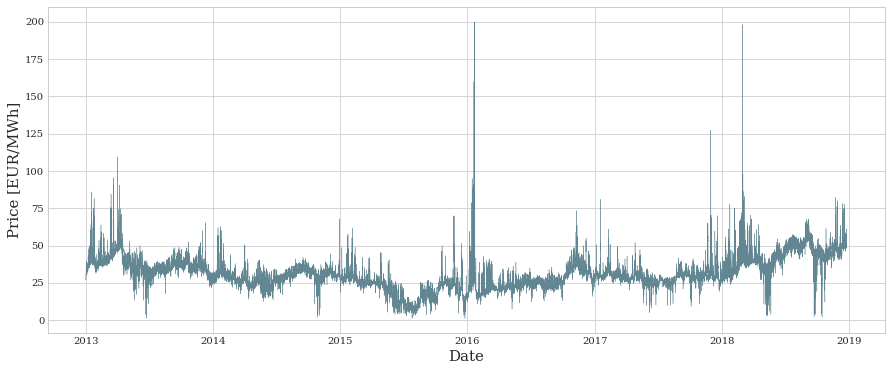

In [ ]:
import pandas as pd
from nixtla.data.datasets.epf import EPF, EPFInfo

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 17

# Load and plot data
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=['NP'])

fig = plt.figure(figsize=(15, 6))
plt.plot(Y_df.ds, Y_df.y.values, color='#628793', linewidth=0.4)
plt.ylabel('Price [EUR/MWh]', fontsize=15)
plt.xlabel('Date', fontsize=15)
# plt.savefig('./results/NP.png', bbox_inches = 'tight')
plt.show()


ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ds_in_test=728*24, verbose=True)

ts_loader = TimeSeriesLoader(ts_dataset=ts_dataset,
                             model='esrnn',
                             #model='nbeats',
                             window_sampling_limit=ts_dataset.max_len, 
                             input_size=24*7,
                             output_size=24,
                             idx_to_sample_freq=24,
                             batch_size=16,
                             complete_inputs=False,
                             len_sample_chunks=24*7*4,
                             complete_sample=False,
                             shuffle=False)

In [ ]:
dataloader = iter(ts_loader)
batch = next(dataloader)

for key, value in batch.items():
    try:
        print(f'{key}.shape', value.shape)
    except:
        print(f'error with {key}')

S.shape (1429, 0)
Y.shape torch.Size([1429, 672])
X.shape torch.Size([1429, 10, 672])
available_mask.shape torch.Size([1429, 672])
sample_mask.shape torch.Size([1429, 672])
idxs.shape (1429,)


# Checks for TimeSeriesLoader's methods
Synthetic data

In [ ]:
import numpy as np
import pandas as pd

n_weeks = 2

Y = np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X1 = -np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])
X2 = 1/(np.concatenate([np.array(range(168*2)), 10*np.array(range(168*2))])+1)

unique_id = np.array(['u1']*168*2 + ['u2']*168*2)
ds = pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list() + \
     pd.date_range(start='1/1/2018', end='1/15/2018', freq='H')[:-1].to_list()

X_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'X1': X1, 'X2': X2})
Y_df = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'y': Y})
S_df = Y_df.drop_duplicates('unique_id')[['unique_id']].reset_index(drop=True)
S_df['s_0'] = [1,0]
S_df['s_1'] = [0,1]

In [ ]:
Y_df

,unique_id,ds,y
0,u1,2018-01-01 00:00:00,0
1,u1,2018-01-01 01:00:00,1
2,u1,2018-01-01 02:00:00,2
3,u1,2018-01-01 03:00:00,3
4,u1,2018-01-01 04:00:00,4
...,...,...,...
667,u2,2018-01-14 19:00:00,3310
668,u2,2018-01-14 20:00:00,3320
669,u2,2018-01-14 21:00:00,3330
670,u2,2018-01-14 22:00:00,3340


In [ ]:
toy_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=None, ds_in_test=5)

In [ ]:
ts_loader = TimeSeriesLoader(ts_dataset=toy_dataset,
                             model='nbeats',
                             window_sampling_limit=toy_dataset.max_len,
                             input_size=5,
                             output_size=5,
                             idx_to_sample_freq=24,
                             batch_size=256,
                             complete_inputs=False,
                             complete_sample=False,
                             shuffle=True)

In [ ]:
dataloader = iter(ts_loader)
batch = next(dataloader)

for key, value in batch.items():
    print(f'{key}.shape', value.shape)

S.shape (256, 2)
Y.shape torch.Size([256, 10])
X.shape torch.Size([256, 2, 10])
available_mask.shape torch.Size([256, 10])
sample_mask.shape torch.Size([256, 10])
idxs.shape (256,)


In [ ]:
batch['S'][:10]

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1]])

In [ ]:
batch['Y']

tensor([[ 211.,  212.,  213.,  ...,  218.,  219.,  220.],
        [1870., 1880., 1890.,  ..., 1940., 1950., 1960.],
        [2350., 2360., 2370.,  ..., 2420., 2430., 2440.],
        ...,
        [1870., 1880., 1890.,  ..., 1940., 1950., 1960.],
        [ 259.,  260.,  261.,  ...,  266.,  267.,  268.],
        [ 910.,  920.,  930.,  ...,  980.,  990., 1000.]])

In [ ]:
batch['X'][0]

tensor([[-2.1100e+02, -2.1200e+02, -2.1300e+02, -2.1400e+02, -2.1500e+02,
         -2.1600e+02, -2.1700e+02, -2.1800e+02, -2.1900e+02, -2.2000e+02],
        [ 4.7170e-03,  4.6948e-03,  4.6729e-03,  4.6512e-03,  4.6296e-03,
          4.6083e-03,  4.5872e-03,  4.5662e-03,  4.5455e-03,  4.5249e-03]])